In [22]:
import pandas as pd
import numpy as np
from difflib import SequenceMatcher
from fuzzywuzzy import fuzz, process
from unidecode import unidecode
import networkx as nx


In [23]:
partido_diputado = pd.read_csv('partidos_diputados.csv', encoding = 'utf8')
partido_diputado['Diputado'] = partido_diputado['Diputado'].apply(unidecode)
print(len(partido_diputado))
partido_diputado.sample(2)

155


,Región,Diputado,Partido
18,Región de Coquimbo (7),Nathalie Castillo Rojas,PCCh
16,Región de Coquimbo (7),Marco Sulantay Olivares,UDI


In [24]:
partidos = {'Enrique Lee Flores' : 'Ind-PRI',
           'Yovana Ahumada Palma' : 'Ind-PDG',
           'Victor Pino Fuentes' : 'Ind-PDG',
           'Gonzalo de la Carrera Correa' : 'Ind-PLR',
           'Pamela Jiles Moreno' : 'PH',
           'Hernan Palma Perez' : 'PH',
           'Francisco Pulgar Castillo' : 'Ind-PL',
           'Gloria Naveillan Arriagada' : 'Ind-PLR',
           'Rene Alinco Bustos' : 'PPD'
           }

partido_diputado['Temp_Partido'] = partido_diputado['Diputado'].map(partidos)
partido_diputado['Partido'] = partido_diputado['Partido'].fillna(partido_diputado['Temp_Partido'])
partido_diputado.drop(columns=['Temp_Partido'], inplace=True)

In [25]:

sectores = {
    'PH' : 'izquierda',
    'Amarillos' : 'centro_izquierda',
    'Ind-RD' : 'izquierda',
    'PEV' : 'izquierda',
    'Ind-PDC' : 'centro_izquierda',
    'FRVS' : 'izquierda',
    'AH' : 'izquierda',
    'PR' : 'centro_izquierda',
    'PPD' : 'centro_izquierda',
    'Ind-PPD' : 'centro_izquierda',
    'PL' : 'centro_izquierda',
    'Ind-PL' : 'centro_izquierda',
    'PDG' : 'populista',
    'Ind-PDG' : 'populista',
    'Ind-CS' : 'izquierda',
    'Demócratas' : 'centro_izquierda',
    'Comunes' : 'izquierda',
    'PDC' : 'centro_izquierda',
    'RD' : 'izquierda',
    'CS' : 'izquierda',
    'PCCh' : 'izquierda',
    'PS' : 'centro_izquierda',
    'Evópoli' : 'centro_derecha',
    'PSC' : 'derecha',
    'Ind-Evópoli' : 'centro_derecha',
    'PLR' : 'derecha',
    'Ind-PLR' : 'derecha',
    'RN' : 'centro_derecha',
    'Ind-RN' : 'centro_derecha',
    'UDI' : 'centro_derecha',
    'Ind-UDI' : 'centro_derecha',
    'Ind-PRI' : 'centro_derecha'
}
partido_diputado['sector'] = partido_diputado['Partido'].map(sectores)
partido_diputado.groupby('sector').size().sort_values()

sector
populista            5
derecha             17
izquierda           40
centro_izquierda    42
centro_derecha      51
dtype: int64

In [26]:
# dataframe con la proporción de agreement
diputados_agreement_df = pd.read_csv('diputados_agreement.csv')
diputados_agreement_df['parliamentarian_1'] = diputados_agreement_df['parliamentarian_1'].apply(unidecode)
diputados_agreement_df['parliamentarian_2'] = diputados_agreement_df['parliamentarian_2'].apply(unidecode)
print(len(diputados_agreement_df))
print(diputados_agreement_df.sample(2))

11935
          parliamentarian_1    parliamentarian_2  proportion_agreement
10504    Moreira, Cristhian      Raphael, Marcia              1.855072
314    Cuello, Luis Alberto  Martinez, Cristobal              0.976285


In [27]:
# Function to perform fuzzy matching using Token Set Ratio
def fuzzy_match_token_set(row, reference_column, target_df, target_column):
    best_match, score = process.extractOne(row[reference_column], target_df[target_column].tolist(), scorer=fuzz.token_set_ratio)
    if score >= 60:  # Threshold for a good match
        return best_match
    else:
        return None

# Perform fuzzy matching for 'parliamentarian_1' and 'parliamentarian_2'
diputados_agreement_df['Fuzzy_Matched_Diputado_1'] = diputados_agreement_df.apply(
    fuzzy_match_token_set,
    axis=1,
    reference_column='parliamentarian_1',
    target_df=partido_diputado,
    target_column='Diputado'
)

diputados_agreement_df['Fuzzy_Matched_Diputado_2'] = diputados_agreement_df.apply(
    fuzzy_match_token_set,
    axis=1,
    reference_column='parliamentarian_2',
    target_df=partido_diputado,
    target_column='Diputado'
)

# Merge the DataFrame based on the fuzzy matched columns for both 'parliamentarian_1' and 'parliamentarian_2'
merged_df_1 = pd.merge(
    diputados_agreement_df,
    partido_diputado[['Diputado', 'Región', 'Partido', 'sector']],
    left_on='Fuzzy_Matched_Diputado_1',
    right_on='Diputado',
    how='left'
).rename(columns={'Región': 'region_1', 'Partido': 'partido_1', 'Diputado': 'Diputado_1', 'sector' : 'sector_1'})

merged_df_2 = pd.merge(
    merged_df_1,
    partido_diputado[['Diputado', 'Región', 'Partido', 'sector']],
    left_on='Fuzzy_Matched_Diputado_2',
    right_on='Diputado',
    how='left'
).rename(columns={'Región': 'region_2', 'Partido': 'partido_2', 'Diputado': 'Diputado_2', 'sector' : 'sector_2'})

# Keep only the columns of interest
df_match_1 = merged_df_2[
    ['parliamentarian_1', 'parliamentarian_2', 'proportion_agreement',
     'region_1', 'region_2', 'partido_1', 'partido_2', 'Diputado_1', 'Diputado_2', 'sector_1', 'sector_2']
]

# Show the first few rows of the final DataFrame
df_match_1.head()

,parliamentarian_1,parliamentarian_2,proportion_agreement,region_1,region_2,partido_1,partido_2,Diputado_1,Diputado_2,sector_1,sector_2
0,"Castillo, Nathalie","Romero, Agustin",0.848485,Región de Coquimbo (7),Región Metropolitana de Santiago (47),PCCh,PLR,Nathalie Castillo Rojas,Agustin Romero Leiva,izquierda,derecha
1,"Castillo, Nathalie","Sanchez, Luis",0.859025,Región de Coquimbo (7),Región de Valparaíso (16),PCCh,PLR,Nathalie Castillo Rojas,Luis Sanchez Ossa,izquierda,derecha
2,"Pizarro, Lorena","Romero, Agustin",0.861660,Región Metropolitana de Santiago (47),Región Metropolitana de Santiago (47),PCCh,PLR,Lorena Pizarro Sierra,Agustin Romero Leiva,izquierda,derecha
3,"Kaiser, Johannes","Serrano, Daniela",0.869565,Región Metropolitana de Santiago (47),Región Metropolitana de Santiago (47),PLR,PCCh,Johannes Kaiser Barents-Von Hohenhagen,Daniela Serrano Salazar,derecha,izquierda
4,"Pizarro, Lorena","Sanchez, Luis",0.872200,Región Metropolitana de Santiago (47),Región de Valparaíso (16),PCCh,PLR,Lorena Pizarro Sierra,Luis Sanchez Ossa,izquierda,derecha


In [28]:
print('len diputados_agreement_df:',len(diputados_agreement_df))
print('len merged_df_1:',len(merged_df_1))
print('len merged_df_2:',len(merged_df_2))
print('len df_match_1:',len(df_match_1))

len diputados_agreement_df: 11935
len merged_df_1: 11935
len merged_df_2: 11935
len df_match_1: 11935


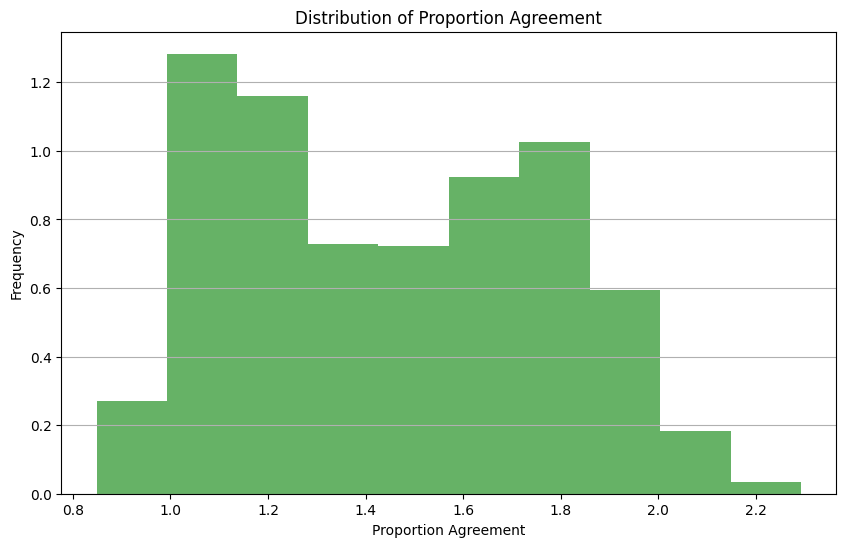

In [29]:
# Re-import necessary libraries
import matplotlib.pyplot as plt

# Plot using Matplotlib's hist function to describe the distribution of the column 'proportion_agreement'
plt.figure(figsize=(10, 6))
plt.hist(df_match_1['proportion_agreement'], bins=10, density=True, alpha=0.6, color='g')
plt.title('Distribution of Proportion Agreement')
plt.xlabel('Proportion Agreement')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [30]:
# prompt: rename dataframe name

df_match_1.rename(columns={'proportion_agreement': 'proportion_agreement'}, inplace=True)
print(df_match_1)


          parliamentarian_1 parliamentarian_2  proportion_agreement  \
0        Castillo, Nathalie   Romero, Agustin              0.848485   
1        Castillo, Nathalie     Sanchez, Luis              0.859025   
2           Pizarro, Lorena   Romero, Agustin              0.861660   
3          Kaiser, Johannes  Serrano, Daniela              0.869565   
4           Pizarro, Lorena     Sanchez, Luis              0.872200   
...                     ...               ...                   ...   
11930  Becker, Miguel Angel  Berger, Bernardo              2.267457   
11931  Becker, Miguel Angel  Sauerbaum, Frank              2.270092   
11932     Barchiesi, Chiara   Romero, Agustin              2.279315   
11933       Romero, Agustin     Sanchez, Luis              2.291173   
11934     Barchiesi, Chiara     Sanchez, Luis              2.292490   

                                    region_1  \
0                     Región de Coquimbo (7)   
1                     Región de Coquimbo (7)   
2  

C:\Users\benja\AppData\Local\Temp\ipykernel_19656\3309790063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match_1.rename(columns={'proportion_agreement': 'proportion_agreement'}, inplace=True)


In [31]:
edgelist_diputados_df = pd.read_csv('Edgelist GPT-O-mini lista cerrada.csv')
#edgelist_diputados_df = pd.read_csv('Edgelist GPT-O-mini lista cerrada.csv')
#edgelist_diputados_df = pd.read_csv('Edgelist PHI-3 lista abierta.csv')
edgelist_diputados_df = edgelist_diputados_df.drop(columns=['Unnamed: 0', 'date', 'original_index'])
edgelist_diputados_df.rename(columns={'persona 1': 'person_1', 'persona 2': 'person_2'}, inplace=True)
edgelist_diputados_df['label'] = edgelist_diputados_df['sentiment']


In [32]:
edgelist_diputados_df = edgelist_diputados_df[edgelist_diputados_df['person_1'] != edgelist_diputados_df['person_2']]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Jose Miguel Durana') & (edgelist_diputados_df['person_2'] != 'Jose Miguel Durana')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Marcela Rios') & (edgelist_diputados_df['person_2'] != 'Marcela Rios')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Sebastian Keitel') & (edgelist_diputados_df['person_2'] != 'Sebastian Keitel')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Carlos Contreras') & (edgelist_diputados_df['person_2'] != 'Carlos Contreras')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Felipe Kast') & (edgelist_diputados_df['person_2'] != 'Felipe Kast')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Ivan Flores') & (edgelist_diputados_df['person_2'] != 'Ivan Flores')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Gustavo Alessandri') & (edgelist_diputados_df['person_2'] != 'Gustavo Alessandri')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Juan Castro') & (edgelist_diputados_df['person_2'] != 'Juan Castro')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Gonzalo Fuenzalida') & (edgelist_diputados_df['person_2'] != 'Gonzalo Fuenzalida')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Karim Bianchi') & (edgelist_diputados_df['person_2'] != 'Karim Bianchi')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Ricardo Yanez') & (edgelist_diputados_df['person_2'] != 'Ricardo Yanez')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Enrique Paris') & (edgelist_diputados_df['person_2'] != 'Enrique Paris')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Francisco Chahuan') & (edgelist_diputados_df['person_2'] != 'Francisco Chahuan')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Barbara Sepulveda') & (edgelist_diputados_df['person_2'] != 'Barbara Sepulveda')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Miguel Landeros') & (edgelist_diputados_df['person_2'] != 'Miguel Landeros')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Daniel Nunez') & (edgelist_diputados_df['person_2'] != 'Daniel Nunez')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Guillermo Teillier') & (edgelist_diputados_df['person_2'] != 'Guillermo Teillier')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Patricio Guenten') & (edgelist_diputados_df['person_2'] != 'Patricio Guenten')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Camila Ahumada') & (edgelist_diputados_df['person_2'] != 'Camila Ahumada')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Carolina Arredondo') & (edgelist_diputados_df['person_2'] != 'Carolina Arredondo')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Juan Luis Castro') & (edgelist_diputados_df['person_2'] != 'Juan Luis Castro')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Jaime Quintana') & (edgelist_diputados_df['person_2'] != 'Jaime Quintana')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Karina Oliva') & (edgelist_diputados_df['person_2'] != 'Karina Oliva')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Francisco Huenchumilla') & (edgelist_diputados_df['person_2'] != 'Francisco Huenchumilla')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Francisca Hernandez') & (edgelist_diputados_df['person_2'] != 'Francisca Hernandez')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Carmen Gloria Aravena') & (edgelist_diputados_df['person_2'] != 'Carmen Gloria Aravena')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Carlos Montes') & (edgelist_diputados_df['person_2'] != 'Carlos Montes')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Hugo Alejandro Contreras Navarro') & (edgelist_diputados_df['person_2'] != 'Hugo Alejandro Contreras Navarro')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Daniel Andrade') & (edgelist_diputados_df['person_2'] != 'Daniel Andrade')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Matias Walker') & (edgelist_diputados_df['person_2'] != 'Matias Walker')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Sergio Hirane') & (edgelist_diputados_df['person_2'] != 'Sergio Hirane')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'German Berger') & (edgelist_diputados_df['person_2'] != 'German Berger')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Natalia Piergentili') & (edgelist_diputados_df['person_2'] != 'Natalia Piergentili')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Marilen Cabrera') & (edgelist_diputados_df['person_2'] != 'Marilen Cabrera')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Felipe Delpin') & (edgelist_diputados_df['person_2'] != 'Felipe Delpin')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Jorge Sharp') & (edgelist_diputados_df['person_2'] != 'Jorge Sharp')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Jaime Ferraz') & (edgelist_diputados_df['person_2'] != 'Jaime Ferraz')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Guillermo San Martin') & (edgelist_diputados_df['person_2'] != 'Guillermo San Martin')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Patricio Pardo Munoz') & (edgelist_diputados_df['person_2'] != 'Patricio Pardo Munoz')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Manuel Jose Ossandon') & (edgelist_diputados_df['person_2'] != 'Manuel Jose Ossandon')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Daniela Aranguiz') & (edgelist_diputados_df['person_2'] != 'Daniela Aranguiz')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Camila Vallejos') & (edgelist_diputados_df['person_2'] != 'Camila Vallejos')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Marcela Sandoval') & (edgelist_diputados_df['person_2'] != 'Marcela Sandoval')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Carlos Kuschel') & (edgelist_diputados_df['person_2'] != 'Carlos Kuschel')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Gustavo Sanhueza') & (edgelist_diputados_df['person_2'] != 'Gustavo Sanhueza')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Juan Cristobal Guarello') & (edgelist_diputados_df['person_2'] != 'Juan Cristobal Guarello')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Rafael Cabrera') & (edgelist_diputados_df['person_2'] != 'Rafael Cabrera')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Camila Vallejo') & (edgelist_diputados_df['person_2'] != 'Camila Vallejo')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Rodolfo Carter') & (edgelist_diputados_df['person_2'] != 'Rodolfo Carter')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Daniel Pacheco') & (edgelist_diputados_df['person_2'] != 'Daniel Pacheco')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Monica Zalaquett') & (edgelist_diputados_df['person_2'] != 'Monica Zalaquett')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Juan Agustin Melendez') & (edgelist_diputados_df['person_2'] != 'Juan Agustin Melendez')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Jaime Escudero') & (edgelist_diputados_df['person_2'] != 'Jaime Escudero')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Pablo Maltes') & (edgelist_diputados_df['person_2'] != 'Pablo Maltes')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Maria Isabel Manzur Nazal') & (edgelist_diputados_df['person_2'] != 'Maria Isabel Manzur Nazal')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Juan Tagle') & (edgelist_diputados_df['person_2'] != 'Juan Tagle')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Daniel Verdessi') & (edgelist_diputados_df['person_2'] != 'Daniel Verdessi')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Manuel Monsalve') & (edgelist_diputados_df['person_2'] != 'Manuel Monsalve')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Fernando Garcia Naddaf') & (edgelist_diputados_df['person_2'] != 'Fernando Garcia Naddaf')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Marcelo Diaz') & (edgelist_diputados_df['person_2'] != 'Marcelo Diaz')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Irina Karamanos') & (edgelist_diputados_df['person_2'] != 'Irina Karamanos')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Nayalet Mansilla Donoso') & (edgelist_diputados_df['person_2'] != 'Nayalet Mansilla Donoso')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Cecilia Morel') & (edgelist_diputados_df['person_2'] != 'Cecilia Morel')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Diego Paulsen') & (edgelist_diputados_df['person_2'] != 'Diego Paulsen')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Marialy Rivas') & (edgelist_diputados_df['person_2'] != 'Marialy Rivas')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Luis Felipe Cespedes') & (edgelist_diputados_df['person_2'] != 'Luis Felipe Cespedes')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Mario Marcel') & (edgelist_diputados_df['person_2'] != 'Mario Marcel')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Cathy Barriga') & (edgelist_diputados_df['person_2'] != 'Cathy Barriga')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Franco Parisi') & (edgelist_diputados_df['person_2'] != 'Franco Parisi')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Javier Macaya') & (edgelist_diputados_df['person_2'] != 'Javier Macaya')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Jordi Castell') & (edgelist_diputados_df['person_2'] != 'Jordi Castell')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Gabriel') & (edgelist_diputados_df['person_2'] != 'Gabriel')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Jara') & (edgelist_diputados_df['person_2'] != 'Jara')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Leopoldo Perez') & (edgelist_diputados_df['person_2'] != 'Leopoldo Perez')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Gonzalo Valenzuela') & (edgelist_diputados_df['person_2'] != 'Gonzalo Valenzuela')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Fabiola Campillai') & (edgelist_diputados_df['person_2'] != 'Fabiola Campillai')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Pablo Vidal') & (edgelist_diputados_df['person_2'] != 'Pablo Vidal')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Jorge Valdivia') & (edgelist_diputados_df['person_2'] != 'Jorge Valdivia')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Nicolas Valenzuela') & (edgelist_diputados_df['person_2'] != 'Nicolas Valenzuela')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Wilson Ureta') & (edgelist_diputados_df['person_2'] != 'Wilson Ureta')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Rocio Norambuena') & (edgelist_diputados_df['person_2'] != 'Rocio Norambuena')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Juan Cristobal Mera') & (edgelist_diputados_df['person_2'] != 'Juan Cristobal Mera')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Juan Sutil') & (edgelist_diputados_df['person_2'] != 'Juan Sutil')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Gaston Saavedra') & (edgelist_diputados_df['person_2'] != 'Gaston Saavedra')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'German Codina') & (edgelist_diputados_df['person_2'] != 'German Codina')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Adan Huentecol') & (edgelist_diputados_df['person_2'] != 'Adan Huentecol')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Antonia Orellana') & (edgelist_diputados_df['person_2'] != 'Antonia Orellana')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Gabriel Boric') & (edgelist_diputados_df['person_2'] != 'Gabriel Boric')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Marco Antonio Avila') & (edgelist_diputados_df['person_2'] != 'Marco Antonio Avila')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Sebastian Piñera') & (edgelist_diputados_df['person_2'] != 'Sebastian Piñera')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Sebastian Pinera') & (edgelist_diputados_df['person_2'] != 'Sebastian Pinera')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Luis Cordero') & (edgelist_diputados_df['person_2'] != 'Luis Cordero')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Carolina Toha') & (edgelist_diputados_df['person_2'] != 'Carolina Toha')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Enrique Van Rysselberghe') & (edgelist_diputados_df['person_2'] != 'Enrique Van Rysselberghe')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Gustavo Sanhueza Dueñas') & (edgelist_diputados_df['person_2'] != 'Gustavo Sanhueza Dueñas')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Gustavo Sanhueza Duenas') & (edgelist_diputados_df['person_2'] != 'Gustavo Sanhueza Duenas')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Paulina Nuñez') & (edgelist_diputados_df['person_2'] != 'Paulina Nuñez')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Paulina Nunez') & (edgelist_diputados_df['person_2'] != 'Paulina Nunez')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Ximena Rincon') & (edgelist_diputados_df['person_2'] != 'Ximena Rincon')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Fernando Araos') & (edgelist_diputados_df['person_2'] != 'Fernando Araos')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Mario Carrera Guerrero') & (edgelist_diputados_df['person_2'] != 'Mario Carrera Guerrero')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Jose Antonio Kast') & (edgelist_diputados_df['person_2'] != 'Jose Antonio Kast')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Cristobal Acevedo') & (edgelist_diputados_df['person_2'] != 'Cristobal Acevedo')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Luis Eduardo Thayer') & (edgelist_diputados_df['person_2'] != 'Luis Eduardo Thayer')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Alvaro Elizalde') & (edgelist_diputados_df['person_2'] != 'Alvaro Elizalde')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Claudio Narea') & (edgelist_diputados_df['person_2'] != 'Claudio Narea')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Luis Cuello') & (edgelist_diputados_df['person_2'] != 'Luis Cuello')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Gonzalo Feito') & (edgelist_diputados_df['person_2'] != 'Gonzalo Feito')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Daniel Jadue') & (edgelist_diputados_df['person_2'] != 'Daniel Jadue')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Antonia Urrejola') & (edgelist_diputados_df['person_2'] != 'Antonia Urrejola')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Monica Salamanca') & (edgelist_diputados_df['person_2'] != 'Monica Salamanca')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Gabriel Silber') & (edgelist_diputados_df['person_2'] != 'Gabriel Silber')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Joaquin Lavin') & (edgelist_diputados_df['person_2'] != 'Joaquin Lavin')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Adriana Barrientos') & (edgelist_diputados_df['person_2'] != 'Adriana Barrientos')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Aldo Mardones') & (edgelist_diputados_df['person_2'] != 'Aldo Mardones')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Alejandra Cox') & (edgelist_diputados_df['person_2'] != 'Alejandra Cox')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Alejandro Kusanovic') & (edgelist_diputados_df['person_2'] != 'Alejandro Kusanovic')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Andrea Parra') & (edgelist_diputados_df['person_2'] != 'Andrea Parra')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Andres Cuyul') & (edgelist_diputados_df['person_2'] != 'Andres Cuyul')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Arturo Squella') & (edgelist_diputados_df['person_2'] != 'Arturo Squella')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Juan Ignacio Latorre') & (edgelist_diputados_df['person_2'] != 'Juan Ignacio Latorre')]
edgelist_diputados_df = edgelist_diputados_df[(edgelist_diputados_df['person_1'] != 'Flavia Torrealba') & (edgelist_diputados_df['person_2'] != 'Flavia Torrealba')]

print(len(edgelist_diputados_df))

3365


In [33]:
edgelist_diputados_df

,person_1,person_2,label,sentiment
0,camila vallejo,gabriel boric,neutral,neutral
1,claudia mix,gabriel boric,positive,positive
2,nathalie castillo,gabriel boric,positive,positive
3,camila vallejo,claudia mix,neutral,neutral
4,camila vallejo,nathalie castillo,neutral,neutral
...,...,...,...,...
3382,renzo trisotti,gastón von mühlenbrock,positive,positive
3383,renzo trisotti,flor weisse,positive,positive
3384,gastón von mühlenbrock,flor weisse,positive,positive
3385,jorge alessandri,catalina pérez,positive,positive


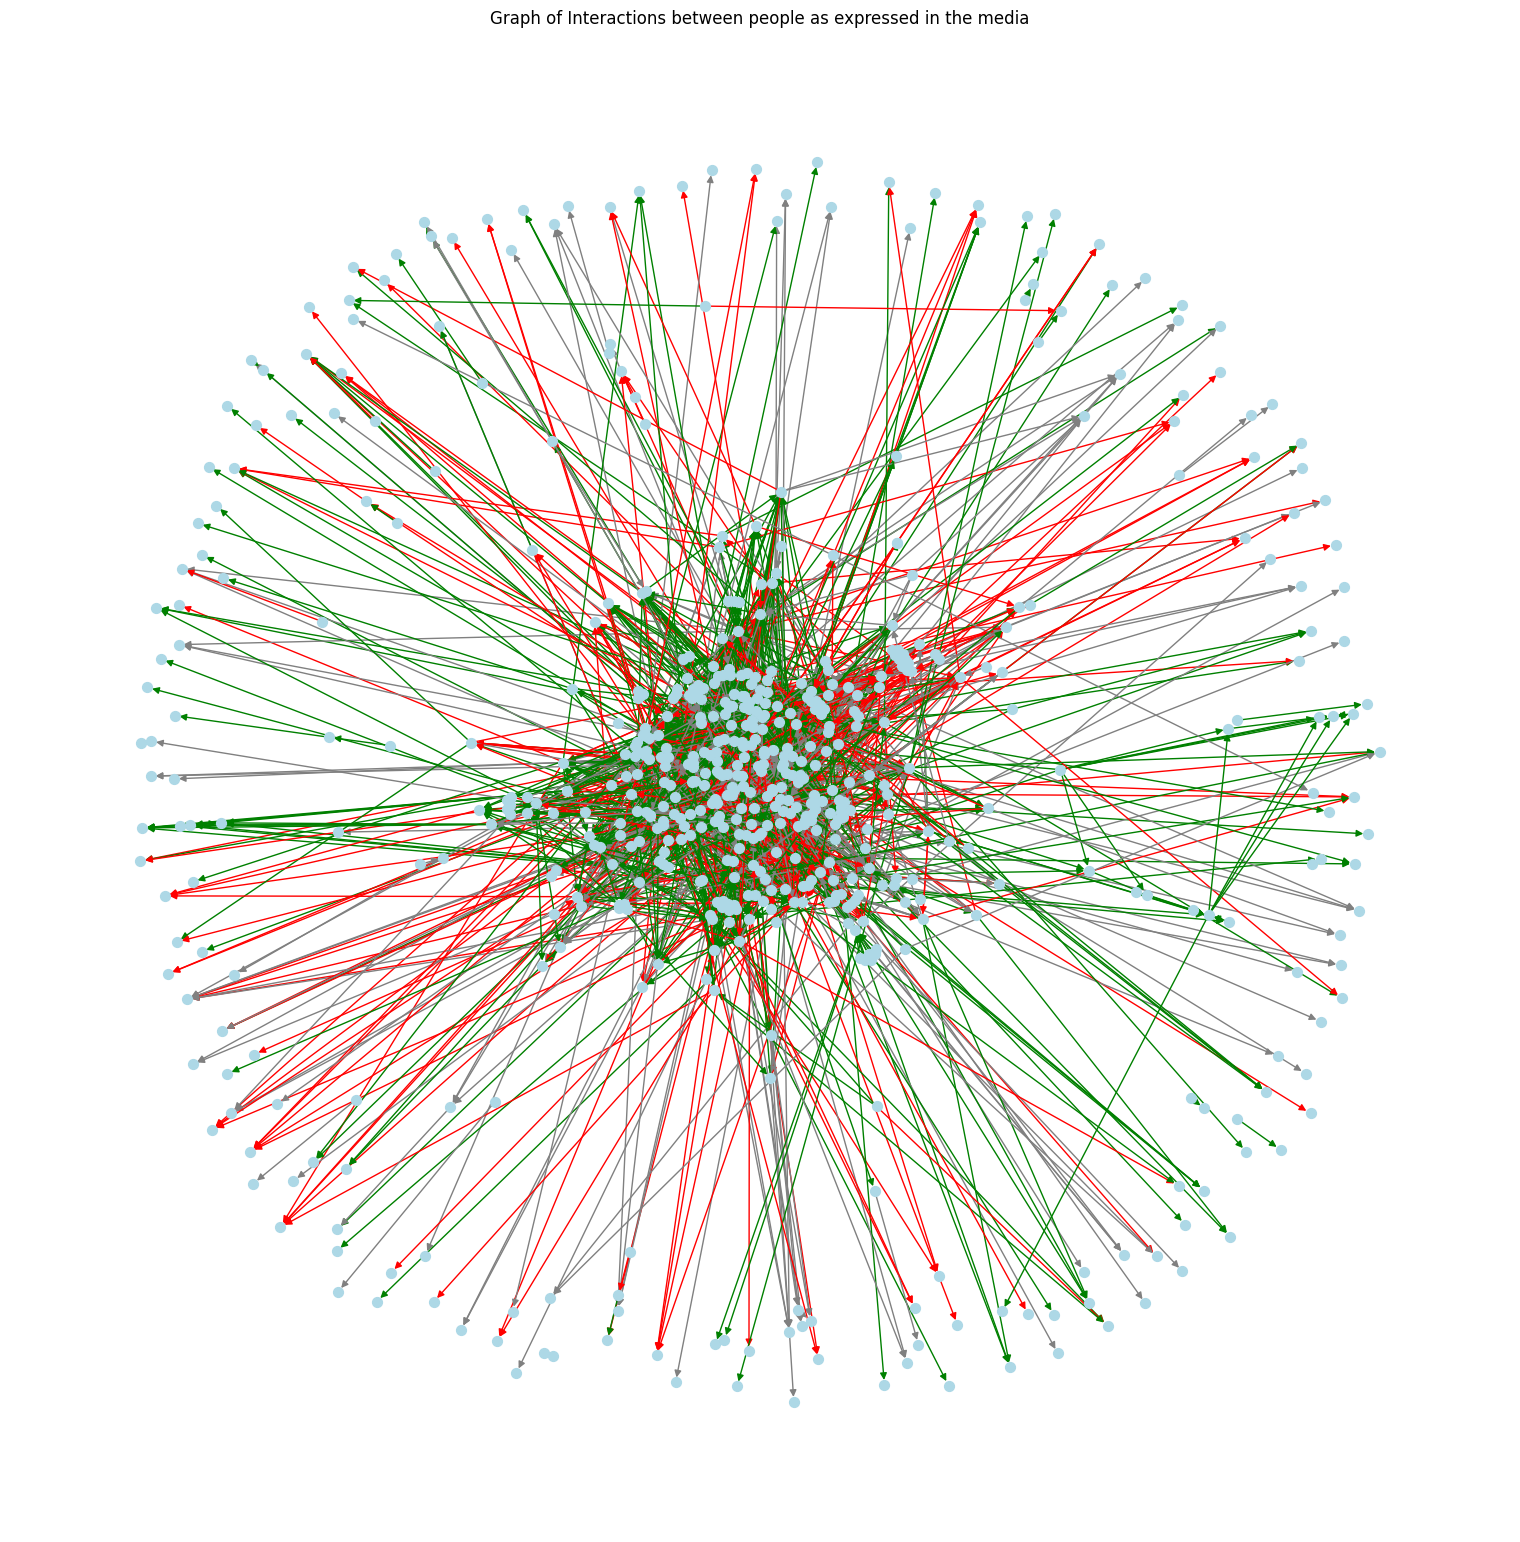

            person_1           person_2     label sentiment  in_degree_1  \
0     camila vallejo      gabriel boric   neutral   neutral           19   
1        claudia mix      gabriel boric  positive  positive            5   
2  nathalie castillo      gabriel boric  positive  positive           12   
3     camila vallejo        claudia mix   neutral   neutral           19   
4     camila vallejo  nathalie castillo   neutral   neutral           19   

   out_degree_1  in_degree_2  out_degree_2  total_degree_1  total_degree_2  \
0            12           78            41              31             119   
1             8           78            41              13             119   
2             8           78            41              20             119   
3            12            5             8              31              13   
4            12           12             8              31              20   

   common_neighbors  
0                10  
1                 5  
2       

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
# Función para obtener el número de vecinos comunes
def common_neighbors_count(graph, node1, node2):
    try:
        # Devuelve la cantidad de vecinos comunes entre node1 y node2
        return len(list(nx.common_neighbors(graph, node1, node2)))
    except:
        return 0

def plot_graph_from_df(df):
    # Crear un grafo dirigido
    G = nx.DiGraph()

    # Añadir las aristas con su sentimiento como atributo
    for _, row in df.iterrows():
        G.add_edge(row['person_1'], row['person_2'], sentiment=row['sentiment'])

    # Definir colores según el sentimiento
    sentiment_colors = {
        'positive': 'green',
        'negative': 'red',
        'neutral': 'gray'
    }

    edge_colors = [sentiment_colors[G[u][v]['sentiment']] for u, v in G.edges]

    # Dibujar el grafo
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, edge_color=edge_colors, with_labels=False, node_color='lightblue', font_size=5, node_size=50)

    plt.title('Graph of Interactions between people as expressed in the media')
    plt.show()

    # Calcular el in-degree, out-degree y degree total
    in_degree_dict = dict(G.in_degree())   # Grados de entrada
    out_degree_dict = dict(G.out_degree())  # Grados de salida
    total_degree_dict = dict(G.degree())    # Grados totales (entrada + salida)

    return in_degree_dict, out_degree_dict, total_degree_dict

# Supongamos que tu DataFrame se llama `data`
in_degree, out_degree, total_degree = plot_graph_from_df(edgelist_diputados_df)

# Añadir los grados al DataFrame original (puedes añadir tanto in-degree como out-degree)
edgelist_diputados_df['in_degree_1'] = edgelist_diputados_df['person_1'].map(in_degree)
edgelist_diputados_df['out_degree_1'] = edgelist_diputados_df['person_1'].map(out_degree)
edgelist_diputados_df['in_degree_2'] = edgelist_diputados_df['person_2'].map(in_degree)
edgelist_diputados_df['out_degree_2'] = edgelist_diputados_df['person_2'].map(out_degree)

# Si quieres añadir el grado total (entrada + salida):
edgelist_diputados_df['total_degree_1'] = edgelist_diputados_df['person_1'].map(total_degree)
edgelist_diputados_df['total_degree_2'] = edgelist_diputados_df['person_2'].map(total_degree)
# Calcular vecinos comunes y añadir al DataFrame
edgelist_diputados_df['common_neighbors'] = edgelist_diputados_df.apply(lambda row: common_neighbors_count(G, row['person_1'], row['person_2']), axis=1)

# Mostrar el DataFrame con los grados añadidos
print(edgelist_diputados_df.head())


In [35]:
len(edgelist_diputados_df)

3365

In [36]:
from fuzzywuzzy import fuzz
import pandas as pd

def find_approximate_match_with_threshold(name, name_list, threshold=60):
    best_match = None
    best_score = -1

    for candidate in name_list:
        score = fuzz.token_set_ratio(name, candidate)

        if score > best_score:
            best_score = score
            best_match = candidate

    if best_score >= threshold:
        return best_match
    else:
        return None

# Extract unique values from df_match_1
unique_parliamentarians_1 = df_match_1['parliamentarian_1'].unique()
unique_parliamentarians_2 = df_match_1['parliamentarian_2'].unique()

# Perform fuzzy matching for unique values
matches_1 = {name: find_approximate_match_with_threshold(name, edgelist_diputados_df['person_1'].tolist()) for name in unique_parliamentarians_1}
matches_2 = {name: find_approximate_match_with_threshold(name, edgelist_diputados_df['person_2'].tolist()) for name in unique_parliamentarians_2}

# Map the dictionary back to df_match_1
df_match_1['approx_match_1_threshold'] = df_match_1['parliamentarian_1'].map(matches_1)
df_match_1['approx_match_2_threshold'] = df_match_1['parliamentarian_2'].map(matches_2)

# Perform the merge
df_merged = pd.merge(df_match_1, edgelist_diputados_df,
                     left_on=['approx_match_1_threshold', 'approx_match_2_threshold'],
                     right_on=['person_1', 'person_2'],
                     how='left')

# Drop the approximate match columns
df_merged.drop(['approx_match_1_threshold', 'approx_match_2_threshold'], axis=1, inplace=True)

C:\Users\benja\AppData\Local\Temp\ipykernel_19656\2156787339.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match_1['approx_match_1_threshold'] = df_match_1['parliamentarian_1'].map(matches_1)


In [37]:
df_merged

,parliamentarian_1,parliamentarian_2,proportion_agreement,region_1,region_2,partido_1,partido_2,Diputado_1,Diputado_2,sector_1,...,person_2,label,sentiment,in_degree_1,out_degree_1,in_degree_2,out_degree_2,total_degree_1,total_degree_2,common_neighbors
0,"Castillo, Nathalie","Romero, Agustin",0.848485,Región de Coquimbo (7),Región Metropolitana de Santiago (47),PCCh,PLR,Nathalie Castillo Rojas,Agustin Romero Leiva,izquierda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Castillo, Nathalie","Sanchez, Luis",0.859025,Región de Coquimbo (7),Región de Valparaíso (16),PCCh,PLR,Nathalie Castillo Rojas,Luis Sanchez Ossa,izquierda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Pizarro, Lorena","Romero, Agustin",0.861660,Región Metropolitana de Santiago (47),Región Metropolitana de Santiago (47),PCCh,PLR,Lorena Pizarro Sierra,Agustin Romero Leiva,izquierda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Kaiser, Johannes","Serrano, Daniela",0.869565,Región Metropolitana de Santiago (47),Región Metropolitana de Santiago (47),PLR,PCCh,Johannes Kaiser Barents-Von Hohenhagen,Daniela Serrano Salazar,derecha,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Pizarro, Lorena","Sanchez, Luis",0.872200,Región Metropolitana de Santiago (47),Región de Valparaíso (16),PCCh,PLR,Lorena Pizarro Sierra,Luis Sanchez Ossa,izquierda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,"Becker, Miguel Angel","Berger, Bernardo",2.267457,Región de la Araucanía (11),Región de Los Ríos (5),RN,Ind-RN,Miguel Becker Alvear,Bernardo Berger Fett,centro_derecha,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12079,"Becker, Miguel Angel","Sauerbaum, Frank",2.270092,Región de la Araucanía (11),Región de Ńuble (5),RN,RN,Miguel Becker Alvear,Frank Sauerbaum Munoz,centro_derecha,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12080,"Barchiesi, Chiara","Romero, Agustin",2.279315,Región de Valparaíso (16),Región Metropolitana de Santiago (47),PLR,PLR,Chiara Barchiesi Chavez,Agustin Romero Leiva,derecha,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12081,"Romero, Agustin","Sanchez, Luis",2.291173,Región Metropolitana de Santiago (47),Región de Valparaíso (16),PLR,PLR,Agustin Romero Leiva,Luis Sanchez Ossa,derecha,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_merged['sentiment'] = df_merged['sentiment'].fillna('no_link_found')

In [39]:
print(len(df_merged))
print(len(df_merged.dropna()))

12083
687


In [40]:
print(df_merged)

          parliamentarian_1 parliamentarian_2  proportion_agreement  \
0        Castillo, Nathalie   Romero, Agustin              0.848485   
1        Castillo, Nathalie     Sanchez, Luis              0.859025   
2           Pizarro, Lorena   Romero, Agustin              0.861660   
3          Kaiser, Johannes  Serrano, Daniela              0.869565   
4           Pizarro, Lorena     Sanchez, Luis              0.872200   
...                     ...               ...                   ...   
12078  Becker, Miguel Angel  Berger, Bernardo              2.267457   
12079  Becker, Miguel Angel  Sauerbaum, Frank              2.270092   
12080     Barchiesi, Chiara   Romero, Agustin              2.279315   
12081       Romero, Agustin     Sanchez, Luis              2.291173   
12082     Barchiesi, Chiara     Sanchez, Luis              2.292490   

                                    region_1  \
0                     Región de Coquimbo (7)   
1                     Región de Coquimbo (7)   
2  

In [19]:
# df_match_2 = df_match_2.dropna().sort_values('proportion_agreement')

In [41]:
 df_merged.to_csv('final_edgelist_gpt_o_mini_lista_cerrada_graph_machinelearning.csv', index = False)